In [19]:
import spacy, stanza
import pandas as pd
import langid
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict


In [20]:
# Load data
data = pd.read_csv('../../data/csv/data.csv')

In [21]:
# Loading SpaCy models
nlp_en = spacy.load("en_core_web_sm")  # English
nlp_es = spacy.load("es_core_news_sm")  # Spanish
nlp_de = spacy.load("de_core_news_sm")  # German
nlp_fr = spacy.load("fr_core_news_sm")  # French
nlp_ru = spacy.load("ru_core_news_sm")  # Russian
nlp_zh = spacy.load("zh_core_web_sm")  # Chinese
nlp_ja = spacy.load("ja_core_news_sm")  # Japanese
nlp_ko = spacy.load("ko_core_news_sm")  # Korean

nlp_ar = stanza.Pipeline(lang='ar') # Arabic

2024-05-05 11:29:01 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-05 11:29:01 INFO: Downloaded file to /Users/perrine/stanza_resources/resources.json
2024-05-05 11:29:02 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-05-05 11:29:02 INFO: Using device: cpu
2024-05-05 11:29:02 INFO: Loading: tokenize
2024-05-05 11:29:02 INFO: Loading: mwt
2024-05-05 11:29:02 INFO: Loading: pos
2024-05-05 11:29:02 INFO: Loading: lemma
2024-05-05 11:29:02 INFO: Loading: depparse
2024-05-05 11:29:02 INFO: Loading: ner
2024-05-05 11:29:03 INFO: Done loading processors!


In [22]:
def tokenize(text: str, lang: str) -> list:
    """
    Permet de tokeniser un texte en fonction de la langue

    Parameters:
    text (str): le texte à tokeniser
    lang (str): la langue du texte

    Returns:
    list: une liste de tokens
    """
    if lang == 'ar':
        doc = nlp_ar(text)
        return [word.text for sent in doc.sentences for word in sent.words]
    else:
        nlp = globals()[f"nlp_{lang}"]
        doc = nlp(text)
        return [token.text for token in doc]

**Tokenisation** : 
- Chaque document est tokenisé selon la langue à l'aide des modèles de NLP correspondants. Les tokens sont les mots dans le cas des langues occidentales et des unités plus complexes pour des langues comme le chinois ou le japonais.

In [23]:
def get_stats(data: pd.DataFrame) -> pd.DataFrame:
    """
    Permet de calculer des statistiques sur les données

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    pd.DataFrame: les statistiques calculées
        n_lang: le nombre de langues
        n_text: le nombre de textes
        n_text_per_lang: le nombre de textes par langue
        mean_tokens_per_text: le nombre moyen de tokens par texte
        n_text_under_100_chars: le nombre de textes de moins de 100 caractères par langue
        ratio_text_under_100_tokens: le ratio de textes de moins de 100 tokens par langue
    """
    languages = defaultdict()
    tokens = defaultdict()
    for i, row in data.iterrows():
        lang = row['Label']
        text = row['Text']
        if lang not in languages:
            languages[lang] = 0
            tokens[lang] = 0
        languages[lang] += 1
        tokens[lang] += len(tokenize(text, lang))

    # Initialisation du dictionnaire pour les statistiques
    stats = defaultdict()

    # Calcul du nombre total de langues
    stats['n_lang'] = len(languages)

    # Calcul du nombre total de textes
    stats['n_text'] = sum(languages.values())

    # Nombre de textes par langue
    stats['n_text_per_lang'] = {}
    for lang in languages:
        stats['n_text_per_lang'][lang] = languages[lang]

    # Nombre moyen de tokens par texte pour chaque langue
    stats['mean_tokens_per_text'] = {}
    for lang in languages:
        stats['mean_tokens_per_text'][lang] = tokens[lang] / languages[lang]

    # Nombre de textes de moins de 100 caractères par langue
    stats['n_text_under_100_tokens'] = {}
    for lang in languages:
        # Initialiser à 0 pour chaque langue
        stats['n_text_under_100_tokens'][lang] = 0
        # Parcourir les données et accumuler le nombre de textes courts
        for i, row in data[data['Label'] == lang].iterrows():
            if len(row['Text']) < 100:
                stats['n_text_under_100_tokens'][lang] += 1

    # Ratio de textes de moins de 100 tokens par langue
    stats['ratio_text_under_100_tokens'] = {}
    for lang in languages:
        # Calculer le nombre total de textes courts en tokens pour chaque langue
        short_texts = 0
        for i, row in data[data['Label'] == lang].iterrows():
            if len(tokenize(row['Text'], lang)) < 100:
                short_texts += 1
        # Calculer le ratio pour chaque langue
        stats['ratio_text_under_100_tokens'][lang] = short_texts / languages[lang] if languages[lang] > 0 else 0

    df_stats = pd.DataFrame({
        "n_text_per_lang": stats['n_text_per_lang'],
        "mean_tokens_per_text": stats['mean_tokens_per_text'],
        "n_text_under_100_tokens": stats['n_text_under_100_tokens'],
        "ratio_text_under_100_tokens": stats['ratio_text_under_100_tokens']
    })

    df_stats["n_lang"] = stats['n_lang']
    df_stats["n_text"] = stats['n_text']

    df_stats = df_stats.reset_index()

    return df_stats

In [24]:
df = get_stats(data)
print(df)

# save the stats
df.to_csv('../../resultats/stats_corpus.csv', index=False)


  index  n_text_per_lang  mean_tokens_per_text  n_text_under_100_tokens  \
0    ar               74            109.000000                        8   
1    de              535             31.620561                       82   
2    ja              283             64.194346                      148   
3    ko              268             29.335821                      159   
4    es              417             49.719424                       24   
5    zh              270             48.674074                      181   
6    ru              615             36.047154                       74   
7    en              667             48.133433                       39   
8    fr              416             49.194712                       18   

   ratio_text_under_100_tokens  n_lang  n_text  
0                     0.567568       9    3545  
1                     1.000000       9    3545  
2                     0.872792       9    3545  
3                     0.996269       9    3545  
4   

In [25]:
def calculate_metrics(data: pd.DataFrame) -> dict:
    """
    Calcule les métriques de diversité lexicale pour chaque langue ainsi que la moyenne globale de tokens par texte 

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    dict: un dictionnaire contenant les métriques
        Average Words per Sample (float): le nombre moyen de tokens par texte
        Lexical Diversity (float): la diversité lexicale
    """

    language_data = defaultdict(list)

    for index, row in data.iterrows():
        tokens = tokenize(row['Text'], row['Label'])
        language_data[row['Label']].append(tokens)
    
    results = {}

    for lang, tokens_list in language_data.items():
        total_words = sum(len(tokens) for tokens in tokens_list)
        total_samples = len(tokens_list)
        unique_words = len(set(word for tokens in tokens_list for word in tokens))
        
        average_words_per_sample = total_words / total_samples if total_samples else 0
        lexical_diversity = unique_words / total_words if total_words else 0

        results[lang] = {
            'Average Words per Sample': average_words_per_sample,
            'Lexical Diversity': lexical_diversity
        }
        results = pd.DataFrame(results)

    return results

**Métriques calculées** :
- **Moyenne des mots par échantillon** : Cela donne une idée de la longueur moyenne des textes pour chaque langue.
- **Diversité lexicale** : C'est le rapport entre le nombre de mots uniques et le nombre total de mots dans les échantillons de chaque langue. Une valeur plus élevée indique une plus grande richesse lexicale.

In [26]:
# Compute metrics
metrics = calculate_metrics(data)

# Display the metrics
print(metrics)

# save the metrics
metrics.to_csv('../../resultats/metrics_corpus.csv')


                                  ar         de         ja         ko  \
Average Words per Sample  109.000000  31.620561  64.194346  29.335821   
Lexical Diversity           0.336474   0.297748   0.203556   0.558509   

                                 es         zh         ru         en  \
Average Words per Sample  49.719424  48.674074  36.047154  48.133433   
Lexical Diversity          0.246226   0.349414   0.355857   0.192711   

                                 fr  
Average Words per Sample  49.194712  
Lexical Diversity          0.236990  


**Affichage des Résultats** : 
- Les résultats sont stockés dans un dictionnaire et imprimés. Vous pouvez également les visualiser en utilisant matplotlib ou une autre bibliothèque de visualisation pour mieux comprendre les distributions.

**1. Coréen (ko)** : Le coréen a un nombre moyen de mots par échantillon de 29.335 et une diversité lexicale la plus élévée à 0.558. Ces valeurs suggèrent des textes relativement courts avec un vocabulaire varié.

**2. Arabe (ar)** : L'arabe présente une moyenne de 109 mots par échantillon avec une diversité lexicale de 0.336. Ces valeurs indiquent des textes plus longs avec une utilisation relativement répétitive du vocabulaire.

**3. Français (fr)** : Avec une moyenne de 49.19 mots par échantillon et une diversité lexicale de 0.237. Ces valeurs suggèrent des textes de longueur modérée avec une utilisation limitée de vocabulaire diversifié.

**4. Chinois (zh)** : Le chinois affiche une moyenne de 48.67 mots par échantillon et une diversité lexicale de 0.349. Ces valeurs suggèrent des textes de longueur modérée avec un vocabulaire varié.

**5. Espagnol (es)** : L'espagnol a une moyenne de 49.72 mots par échantillon avec une diversité lexicale de 0.246. Ces valeurs suggèrent des textes de longueur modérée avec une utilisation limitée de vocabulaire diversifié.

**6. Russe (ru)** : Le russe, avec une moyenne de 36.047 mots et une diversité lexicale de 0.356, montre une utilisation variée du vocabulaire dans des textes relativement courts.

**7. Allemand (de)** : Avec une moyenne de 31.62 mots et une diversité lexicale de 0.297, l'allemand montre une utilisation variée du vocabulaire dans des textes relativement courts.

**8. Japonais (ja)** : Le japonais a une moyenne de 64.19 mots par échantillon avec une diversité lexicale de 0.203. Ces valeurs suggèrent des textes plus longs avec une utilisation répétitive de certains termes.

**9. Anglais (en)** : L'anglais affiche un nombre moyen de mots de 48.13 par échantillon avec la diversité lexicale la plus basse à 0.198. Ceci indique une tendance à des textes concis avec une utilisation limitée de vocabulaire diversifié.

        Token  Frequency  Rank Language
0           ل   0.000372   1.0       ar
1           ،   0.000248   2.5       ar
2       تعداد   0.000248   2.5       ar
3      الحمرة   0.000124  17.0       ar
4     مديريات   0.000124  17.0       ar
..        ...        ...   ...      ...
22      ovale   0.000049  17.0       fr
23  disposées   0.000049  17.0       fr
24       cinq   0.000049  17.0       fr
25         un   0.000049  17.0       fr
26         d'   0.000049  17.0       fr

[124786 rows x 4 columns]


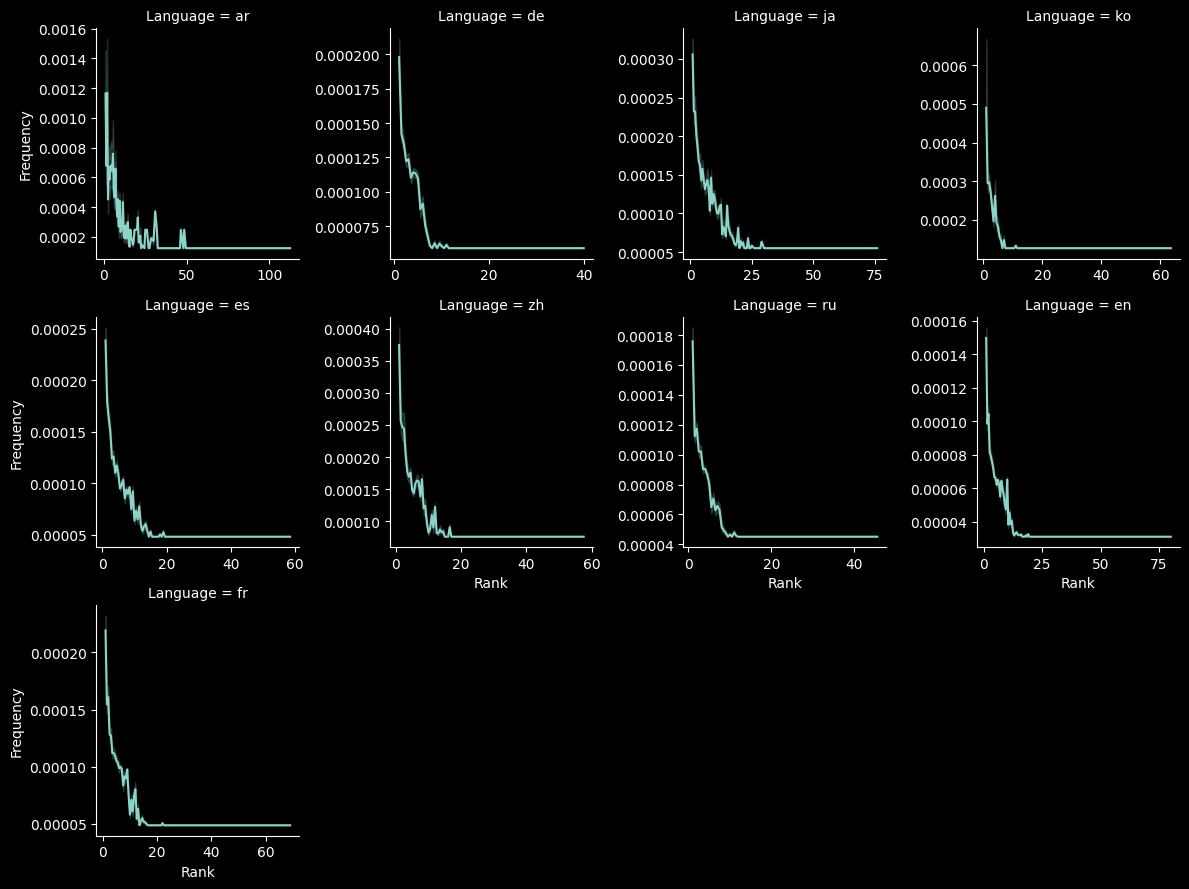

In [30]:
def loi_zipf_par_lang(data: pd.DataFrame) -> pd.DataFrame:
    """
    Calcule la loi de Zipf pour chaque langue.

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    pd.DataFrame: un DataFrame contenant les résultats.
    """
    results = defaultdict(list)

    for text, lang in zip(data['Text'], data['Label']):
        lang = langid.classify(text)[0] if lang == 'unknown' else lang
        tokens = tokenize(text, lang)
        freq = pd.Series(tokens).value_counts()
        freq = freq.reset_index()
        freq.columns = ['Token', 'Frequency']
        freq['Rank'] = freq['Frequency'].rank(ascending=False)
        freq['Language'] = lang
        results[lang].append(freq)

    dfs = []
    for lang, lang_freqs in results.items():
        lang_freqs_df = pd.concat(lang_freqs)
        lang_freqs_df['Frequency'] = lang_freqs_df['Frequency'] / lang_freqs_df['Frequency'].sum()
        dfs.append(lang_freqs_df)
    return pd.concat(dfs)

zipf_results = loi_zipf_par_lang(data)
print(zipf_results)

def plot_zipf(data: pd.DataFrame) -> plt.Figure:
    """
    Crée un graphique de la loi de Zipf pour chaque langue.

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    plt.Figure: l'objet Figure contenant le graphique
    """
    g = sns.FacetGrid(data, col='Language', col_wrap=4, sharex=False, sharey=False)
    g.map(sns.lineplot, 'Rank', 'Frequency')

    return g.fig

zipf = plot_zipf(zipf_results)
zipf.savefig('../../resultats/zipf.png')


1. **`loi_zipf_par_lang(data: pd.DataFrame) -> pd.DataFrame`**:
   Cette fonction calcule la loi de Zipf pour chaque langue dans un DataFrame donné. 

   Voici ce qu'elle fait :
   - Prend en entrée un DataFrame `data` contenant des colonnes "Text" (texte à analyser) et "Label" (langue du texte).
   - Initialise un dictionnaire `results` par défaut, qui va stocker les résultats de la loi de Zipf pour chaque langue.
   - Parcourt chaque texte et sa langue correspondante dans le DataFrame. Si la langue est "unknown", elle est détectée à l'aide de `langid.classify(text)`.
   - Tokenise le texte en utilisant la fonction `tokenize(text, lang)`.
   - Compte la fréquence des tokens à l'aide de `pd.Series(tokens).value_counts()` et les classe par ordre décroissant.
   - Normalise les fréquences en divisant par la somme des fréquences.
   - Stocke les résultats dans le dictionnaire `results`.
   - Concatène tous les DataFrames de résultats pour chaque langue dans une seule DataFrame et la retourne.

2. **`plot_zipf(data: pd.DataFrame) -> None`**:
   Cette fonction trace la loi de Zipf pour chaque langue dans un DataFrame donné. 
   
   Voici ce qu'elle fait :
   - Prend en entrée un DataFrame `data` contenant les résultats de la loi de Zipf pour chaque langue.
   - Crée une grille de facettes (`FacetGrid`) de seaborn avec une colonne pour chaque langue, en utilisant `sns.FacetGrid`.
   - Pour chaque langue, trace un graphique de ligne montrant la relation entre le rang et la fréquence à l'aide de `sns.lineplot`.
   - Retourne le tracé à l'aide de `return g.fig`.

En résumé, la première fonction calcule les statistiques de la loi de Zipf pour chaque langue dans les données, tandis que la deuxième fonction trace ces statistiques pour chaque langue.

Interprétation des résultats :
Les sous-graphiques, intitulés selon leurs langues respectives, affichent des schémas similaires :

1. **Schéma décroissant :** Tous les graphiques montrent une diminution rapide de la fréquence des mots à mesure que le rang augmente. Cela est conforme à la loi de Zipf, qui stipule que la fréquence d'un mot est inversement proportionnelle à son rang dans le tableau des fréquences. En d'autres termes, les mots les plus utilisés ont une fréquence élevée, qui diminue rapidement pour les mots moins utilisés.

2. **Différentes échelles :** Bien que les schémas soient similaires, les échelles des axes diffèrent d'une langue à l'autre. Par exemple, la fréquence maximale varie d'une langue à l'autre, ce qui indique des différences dans la distribution de l'utilisation des mots.

3. **Longue traîne :** La plupart des graphiques présentent une longue traîne, indiquant que de nombreux mots sont utilisés avec une fréquence relativement faible. Ceci est typique pour les langues naturelles, où un petit nombre de mots est très fréquemment utilisé, tandis que la plupart des mots sont utilisés de manière peu fréquente.
